In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [3]:
connection_test = dict(database='test',
                  host='https://clickhouse.lab.karpov.courses',
                  user='student-rw',
                  password='656e2b0c9c')

In [4]:
# создаем запрос, db автоматически заменится на значение из database
q = '''
    SELECT 
        UserID 
    FROM 
        {db}.checks 
    LIMIT 10
    '''

# отправляем запрос и записываем результат в пандасовский датафрейм
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,UserID
0,18446583642950580515
1,18446535622689003675
2,18446130411954852964
3,18446003252714243011
4,18445948434655311802
5,18445927732647659917
6,18445761122620052505
7,18445655133428855896
8,18445587876544434519
9,18445586451093345117


In [5]:
q = """
CREATE TABLE IF NOT EXISTS test.example_table (
    id UInt32,
    supplementary_id UInt32,
    comments String 
) 
ENGINE = MergeTree 
ORDER BY (id, supplementary_id)
"""

ph.execute(query=q, connection=connection_test)

b''

In [6]:
# проверяем количество строк в получившемся датасете
q_2 = ''' SELECT COUNT() FROM ldn_listings'''
q_test_2 = ph.read_clickhouse(query=q_2, connection=connection_default)
q_test_2

,count()
0,85207


Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:
price – цена за ночь
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)

Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id

In [7]:
# также в запросе необходимо привести колонку 'price' к удобному для обработки формату, убрать лишние символы и пробелы
q_3 = '''SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price
FROM ldn_listings
ORDER BY id ASC
LIMIT 1000'''
q_test_3 = ph.read_clickhouse(query=q_3, connection=connection_default)
q_test_3.head(5)

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0


Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

In [8]:
q_test_3.groupby('room_type').price.quantile(q=0.75)

room_type
Entire home/apt    160.00
Hotel room         157.00
Private room        70.00
Shared room         69.25
Name: price, dtype: float64

К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). 
В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.
Также нужно построить график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

In [9]:
# пишем запрос, так же убирая лишние символы и пробелы из колонок 'price' и 'review_scores_rating'
q_4 = '''SELECT room_type, 
    toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price, 
    toFloat32OrNull(review_scores_rating) as review_scores_rating 
FROM default.ldn_listings
where review_scores_rating is not null
order by id ASC
limit 1000'''
q_test_4 = ph.read_clickhouse(query=q_4, connection=connection_default)
q_test_4

,room_type,price,review_scores_rating
0,Private room,65.0,97.0
1,Entire home/apt,100.0,96.0
2,Entire home/apt,300.0,94.0
3,Entire home/apt,65.0,93.0
4,Private room,29.0,96.0
...,...,...,...
995,Entire home/apt,165.0,100.0
996,Private room,99.0,93.0
997,Private room,45.0,100.0
998,Private room,20.0,88.0


In [10]:
# группируем таблицу для построения графика
df = q_test_4.groupby('room_type', as_index=False)['price', 'review_scores_rating'].mean()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [11]:
df

,room_type,price,review_scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


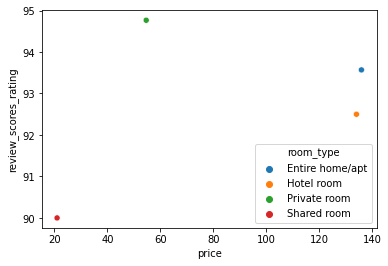

In [12]:
# строим график
sns.scatterplot(data = df, x="price", y="review_scores_rating", hue="room_type")

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [13]:
# пишем запрос, который оставляет только те "host_id", у которых значения "experiences_offered" не пустое
q_5 = """SELECT DISTINCT(host_id), host_verifications
FROM ldn_listings
WHERE experiences_offered != 'none'"""
q_test_5 = ph.read_clickhouse(query=q_5, connection=connection_default)
q_test_5

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [14]:
# пишем функцию для определения количества способов верификации
q_test_5.host_verifications.apply(lambda x: eval(x)).explode().value_counts()

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. 

Сгруппируем данные по району и виду впечатления и посчитаем количество объявлений.
Отсортируем данные по убыванию experiences_count и выгрузим первые 100 строк. 
Затем преобразуем данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. 

In [15]:
# пишем запрос
q_6 = '''SELECT neighbourhood_cleansed, experiences_offered, count(experiences_offered) as experiences_count
FROM ldn_listings
WHERE experiences_offered != 'none'
group by neighbourhood_cleansed, experiences_offered
order by experiences_count desc
limit 100'''
q_test_6 = ph.read_clickhouse(query=q_6, connection=connection_default)
q_test_6

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [16]:
# необходимо преобразовать таблицу для визуализации
df = q_test_6.pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count').fillna(0)

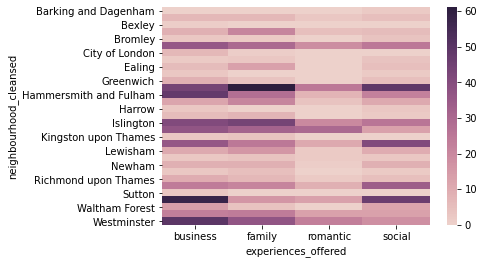

In [17]:
sns.heatmap(df, cmap=sns.cubehelix_palette(as_cmap=True)) 

Выгрузим данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления.

In [18]:
# пишем запрос
q_7 = """SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr
FROM ldn_listings
WHERE experiences_offered != 'none'"""
df = ph.read_clickhouse(query=q_7, connection=connection_default)
df

,room_type,price_corr
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


In [19]:
# смотрим уникальные значения типа комнат (room_type)
df.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

Также построим два графика, используя distplot из библиотеки seaborn.
На первом отобразим исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


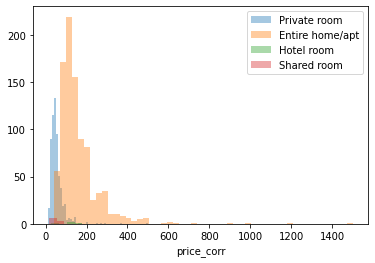

In [20]:
sns.distplot(df.query("room_type=='Private room'").price_corr, kde=False, label='Private room')
sns.distplot(df.query("room_type=='Entire home/apt'").price_corr, kde=False, label='Entire home/apt')
sns.distplot(df.query("room_type=='Hotel room'").price_corr, kde=False, label='Hotel room')
sns.distplot(df.query("room_type=='Shared room'").price_corr, kde=False, label='Shared room')
plt.legend()
plt.show()

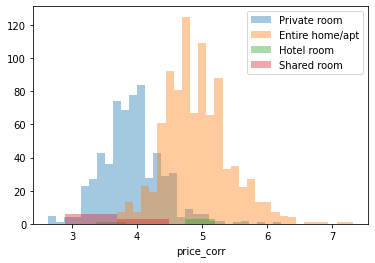

In [21]:
sns.distplot(np.log(df.query("room_type=='Private room'").price_corr), kde=False, label='Private room')
sns.distplot(np.log(df.query("room_type=='Entire home/apt'").price_corr), kde=False, label='Entire home/apt')
sns.distplot(np.log(df.query("room_type=='Hotel room'").price_corr), kde=False, label='Hotel room')
sns.distplot(np.log(df.query("room_type=='Shared room'").price_corr), kde=False, label='Shared room')
plt.legend()
plt.show()

Выгрузим данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года.

In [22]:
q_8 = """SELECT room_type, toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) as price_corr, first_review
FROM ldn_listings
WHERE first_review > '2010-01-01'
limit 1000"""

In [23]:
df = ph.read_clickhouse(query=q_8, connection=connection_default)
# приводим колонку "first_review" к году
df['first_review'] = pd.to_datetime(df['first_review']).dt.year

In [24]:
# сортируем значения колонки 'first_review' по возрастанию
df = df.sort_values('first_review', ascending = True)

Построим график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии) по годам (ось X). Датафрейм отсортирован по годам.

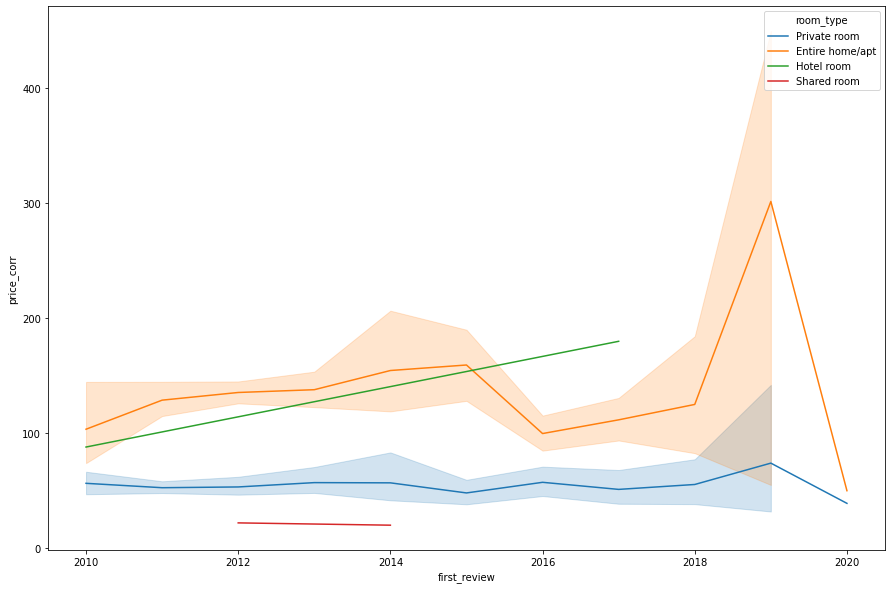

In [25]:
# строим график
plt.figure(figsize=(15, 10))
sns.lineplot(x='first_review',y='price_corr',hue='room_type',data=df)